In [ ]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils
import gpfunctions as gp
import lstm_model

In [143]:
import imp
imp.reload(gp)

<module 'gpfunctions' from '/Users/heytitle/projects/neural-network-project/gpfunctions.py'>

In [ ]:
import matplotlib.pylab as pylab
params = {
    'axes.labelsize': 'xx-large',
    'xtick.labelsize':'xx-large',
    'ytick.labelsize':'xx-large'
}
pylab.rcParams.update(params)

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
LOSS_FUNCS = ['MIN', 'OI', 'SUM']

In [87]:
def find_y_from_lstm(X_test, A_test, min_test, max_test, kernel, dim, loss, n_steps=20, debug=False, dataset="normal"):
    print('LSTM on %s dataset' % dataset)
    model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
    starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]

    data_Xt = X_test
    data_At  = A_test
    data_mint = min_test.reshape(-1,1)
    data_maxt = max_test.reshape(-1,1)

    model_params = lstm_model.load_model_params(model, debug=False)

    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': n_steps,
            'l': 2.0/6*np.sqrt(dim),
            'scope': model_params['scope'],
            'function': gp.dataset_function(dataset),
            'kernel': gp.kernel_function(kernel)
        }

        Xt, At, mint, maxt, samples_x, samples_y, x_0, _, _ = lstm_model.build_training_graph(**params_dict)

        saver = tf.train.Saver()
        saver.restore(sess, model_params['model_path'])

        feed_dict = {
            Xt: data_Xt,
            At: data_At,
            mint: data_mint,
            maxt: data_maxt,
            x_0: np.array(starting_point).reshape(1,-1)
        }

        res, res_x = sess.run([samples_y, samples_x], feed_dict=feed_dict)

        return np.array(res).reshape(n_steps+1,-1).T



In [104]:
def load_data(method, dim, kernel, dataset, suffix):
    if dataset != 'normal':
        dataset = '-%s'%dataset
    else:
        dataset = ''
        
    return np.load('./skopt-result/%s/%dd-%s%s-samples_y%s.npy' % (method, dim, kernel, dataset, suffix))

def plot_min_comparison_of_dim_and_kernel(dim, kernel, steps=21, xtick_step=2, dataset="normal", suffix="", baseline_methods=['gp', 'gbrt', 'forest', 'basinhopping']):
    
    # load SKOPT
    for method in baseline_methods:
        skopt_y = load_data(method, dim, kernel, dataset, suffix)
        skopt_y, _ = utils.average_min_found_values_across_rows(skopt_y)
    
        skopt_y = skopt_y[:steps]

        key = 'SKOPT-%s' % method.upper()
        if method is 'basinhopping':
            key = 'SCIPY-%s' % method.upper()
        plt.plot(skopt_y, label=key)
    
    # load test data

    
    # load RANDOM    
    random_y = load_data('random', dim, kernel, dataset, suffix)
    
    random_y, _ = utils.average_min_found_values_across_rows(random_y)[:steps]
    plt.plot(random_y, label='UNIFORM-SAMPLING')

    print('load testing data for %dd-%s'% (dim, kernel ))
    X_test, A_test, min_test, max_test = utils.loadData(dim, 'testing', kernel)
    

    # load LSTM data
    for loss in LOSS_FUNCS:
        y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernel, loss=loss, n_steps = steps-1, dataset=dataset)

        y_values, _ = utils.average_min_found_values_across_rows(y_values)
        plt.plot(y_values, label='LSTM-%s'%loss, marker = 'o')
#     using model trained on different kernel
    kernelb = 'rbf' if kernel is 'matern32' else 'matern32'
    y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernelb, loss='MIN',  n_steps = steps-1, dataset=dataset)
    y_values, _ = utils.average_min_found_values_across_rows(y_values)

    plt.plot(y_values, label='LSTM-%s-%s'%('MIN',kernelb), marker = '^')

    
    xticks = range(0, steps, xtick_step)
    yticks = np.arange(-1.2, 0.2, 0.2)
    plt.ylabel('Min Found')
    plt.xlabel('Evaluation Step')
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.title('%dD-%s-%s' % (dim, kernel.upper(), dataset))

def plot_comparision_of_dim(dim, steps=21):
    kernels = ['rbf','matern32']
    plt.figure(figsize=(15,4))
    
    for i in range(len(kernels)):
        plt.subplot(1,2,i+1)
        plot_min_comparison_of_dim_and_kernel(dim=dim, kernel=kernels[i], steps=steps)

In [ ]:
plot_comparision_of_dim(dim=1)
plt.legend()

In [ ]:
plot_comparision_of_dim(dim=2)
plt.legend()

In [ ]:
plot_comparision_of_dim(dim=3)
plt.legend()

In [ ]:
plot_comparision_of_dim(dim=4)
plt.legend()

In [74]:
plot_comparision_of_dim(dim=6)
plt.legend()

load testing data for 4d-rbf
load testing data for 6d-rbf


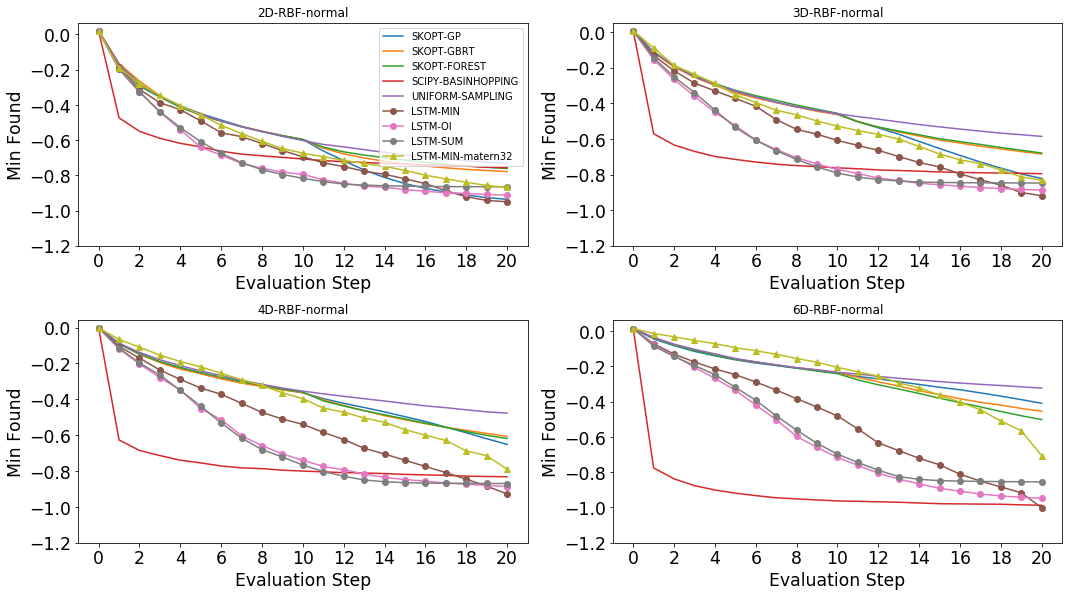

In [75]:
def plot_for_poster(kernel='rbf',dataset="normal"):
    dims = [2,3,4,6]
    total_dims = len(dims)
    plt.figure(figsize=(15,4*total_dims))
    count = 0
    for d in range(total_dims):
        dim = dims[d]

        plt.subplot(total_dims,2,count+1)
        plot_min_comparison_of_dim_and_kernel(dim=dim, kernel=kernel, dataset="normal")

        if count == 0:
            plt.legend()
        count = count + 1
    plt.tight_layout()
plot_for_poster()
plt.savefig('min-test.svg')

load testing data for 2d-matern32
load testing data for 3d-matern32
load testing data for 4d-matern32
load testing data for 6d-matern32


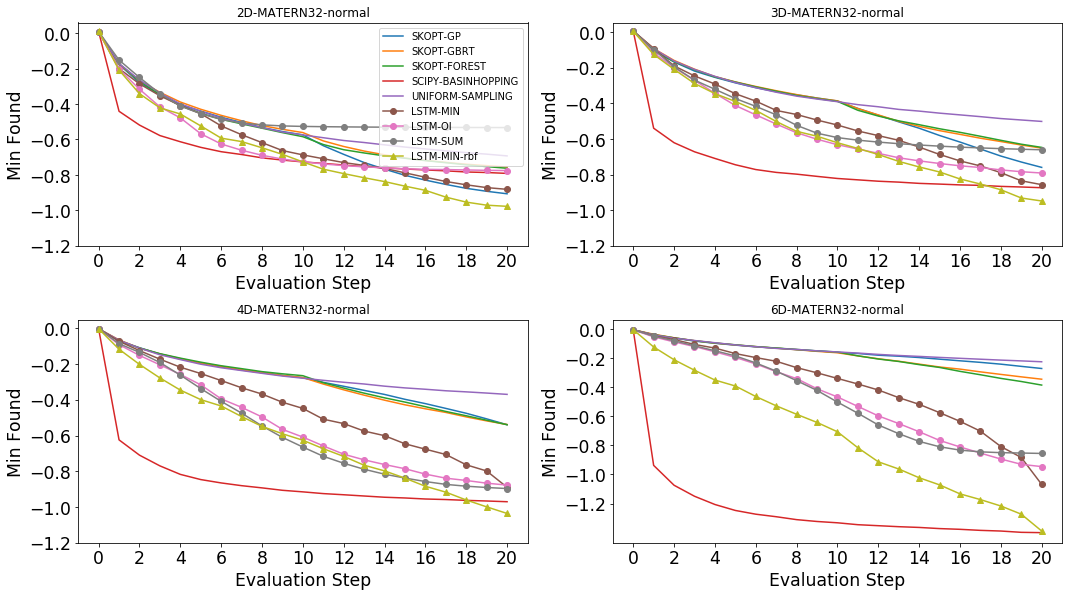

In [76]:
plot_for_poster(kernel="matern32")

# Combined rbf + matern32 distribution

load testing data for 2d-rbf
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset


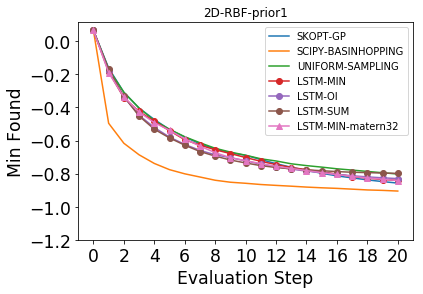

In [147]:
plot_min_comparison_of_dim_and_kernel(dim=2, kernel='rbf', dataset='prior1', steps=21, baseline_methods=['gp','basinhopping'])
plt.legend()

load testing data for 3d-rbf
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset


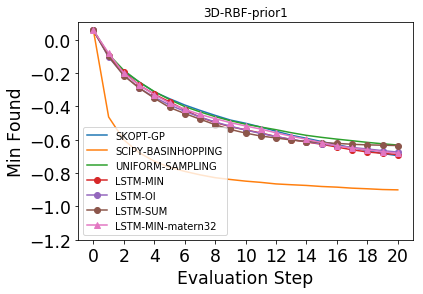

In [146]:
plot_min_comparison_of_dim_and_kernel(dim=3, kernel='rbf', dataset='prior1', steps=21, baseline_methods=['gp','basinhopping'])
plt.legend()

load testing data for 4d-rbf
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset


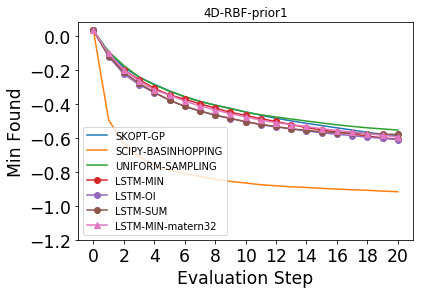

In [145]:
plot_min_comparison_of_dim_and_kernel(dim=4, kernel='rbf', dataset='prior1', steps=21, baseline_methods=['gp','basinhopping'])
plt.legend()

load testing data for 6d-rbf
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset


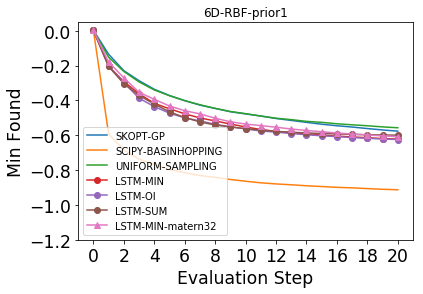

In [144]:
plot_min_comparison_of_dim_and_kernel(dim=6, kernel='rbf', dataset='prior1', steps=21, baseline_methods=['gp','basinhopping'])
plt.legend()

load testing data for 2d-rbf
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
load testing data for 3d-rbf
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
load testing data for 4d-rbf
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
load testing data for 6d-rbf
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset
LSTM on prior1 dataset


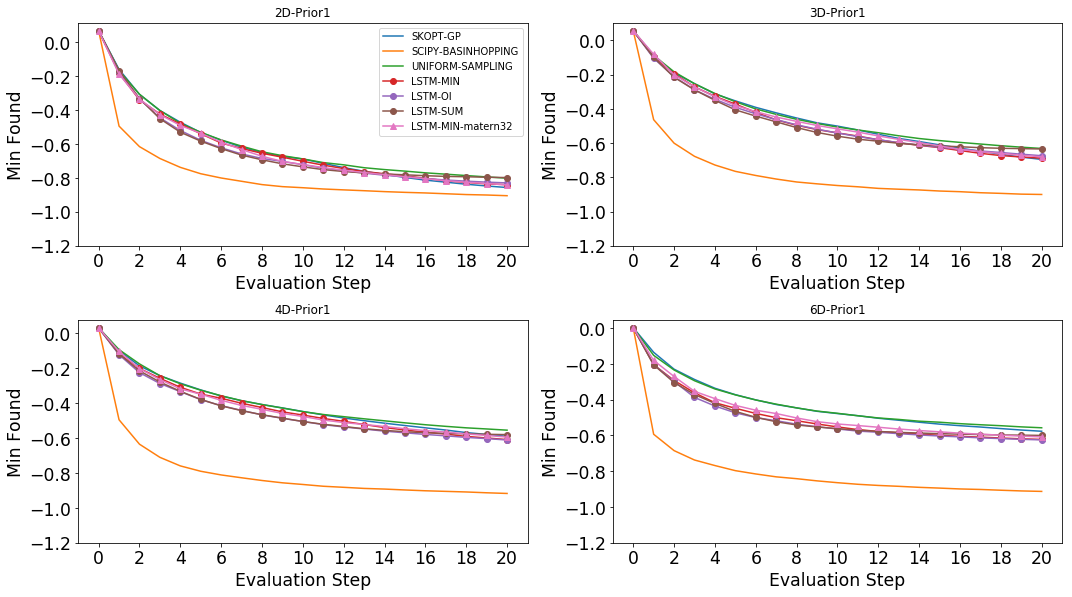

In [149]:
dims = [2,3,4,6]
total_dims = len(dims)
plt.figure(figsize=(15,4*total_dims))
count = 0
for d in range(total_dims):
    dim = dims[d]

    plt.subplot(total_dims,2,count+1)
    plot_min_comparison_of_dim_and_kernel(dim=dim, kernel='rbf', dataset='prior1', steps=21, baseline_methods=['gp','basinhopping'])
    plt.title('%dD-Prior1' % dim)
    if count == 0:
        plt.legend()
    count = count + 1
plt.tight_layout()

# 100 Steps

In [ ]:
BASELINES_100N = ['gp', 'basinhopping']

In [ ]:
plt.figure(figsize=(18,5))
plot_min_comparison_of_dim_and_kernel(dim=6, kernel='rbf', steps=101, xtick_step=5, baseline_methods=BASELINES_100N)
plt.legend()
plt.savefig('100steps.svg')

In [ ]:
plt.figure(figsize=(18,5))

plot_min_comparison_of_dim_and_kernel(dim=6, kernel='matern32', steps=101, xtick_step=5, baseline_methods=BASELINES_100N)
plt.legend()

## Obsoleted code

In [ ]:
basin_y = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % ('basinhopping', 2, 'rbf'))
basin_x = np.load('./skopt-result/%s/%dd-%s-samples_x.npy' % ('basinhopping', 2, 'rbf'))

In [ ]:
basin_y_mat = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % ('basinhopping', 2, 'matern32'))
basin_x_mat = np.load('./skopt-result/%s/%dd-%s-samples_x.npy' % ('basinhopping', 2, 'matern32'))

basin_y_gp_rbf = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % ('gp', 2, 'rbf'))
basin_x_gp_rbf = np.load('./skopt-result/%s/%dd-%s-samples_x.npy' % ('gp', 2, 'rbf'))

In [150]:
random_y1_rbf = np.load('./skopt-result/%s/%dd-%s-prior1-samples_y.npy' % ('basinhopping', 3, 'rbf'))
random_y2_rbf = np.load('./skopt-result/%s/%dd-%s-prior1-samples_x.npy' % ('basinhopping', 2, 'rbf'))

In [151]:
a, _ = utils.average_min_found_values_across_rows(random_y1_rbf)
b, _ = utils.average_min_found_values_across_rows(random_y2_rbf)

In [153]:
random_y2_rbf = np.load('./skopt-result/%s/%dd-%s-prior1-samples_x.npy' % ('basinhopping', 2, 'rbf'))

In [ ]:
basin_y[:,0]

In [ ]:
basin_y_mat[:,0]

In [ ]:
basin_y_gp_rbf[:,0]

In [ ]:
# def pppp(dim, kernel, steps=21):
    
#     # load SKOPT
# #     for method in ['gp', 'gbrt', 'forest']:
#     for method in ['gp']:
#         skopt_y = np.load('./skopt-result/%s/%dd-%s-samples_y.npy' % (method, dim, kernel))
#         skopt_y = average_min_found_values_across_rows(skopt_y)[:steps]
#         key = 'SKOPT-%s' % method.upper()
#         plt.plot(skopt_y, label=key)
    
#     # load test data
#     X_test, A_test, min_test, max_test = utils.loadData(dim, 'testing', kernel)
    

#     # load LSTM data
#     for loss in LOSS_FUNCS:
#         y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernel, loss=loss, n_steps = steps - 1)
       
#         y_values = average_min_found_values_across_rows(y_values)
# #         if loss is 'MIN':
# #             print(y_values)
#         plt.plot(y_values, label='LSTM-%s'%loss, marker = 'o')
    
#     # using model trained on different kernel
#     kernelb = 'rbf' if kernel is 'matern32' else 'matern32'
#     y_values = find_y_from_lstm(X_test, A_test, min_test, max_test, dim=dim, kernel=kernelb, loss='MIN', n_steps = steps - 1)
#     y_values = average_min_found_values_across_rows(y_values)

#     plt.plot(y_values, label='LSTM-%s-%s'%('MIN',kernelb), marker = '^')

    
# #     xticks = range(0, steps, 2)
#     yticks = np.arange(-1.2, 0.2, 0.2)
#     plt.ylabel('Min Found')
#     plt.xlabel('Evaluation Step')
# #     plt.xticks(xticks)
#     plt.yticks(yticks)
#     plt.title('%dD-%s' % (dim, kernel.upper()))
    
# # plt.figure(figsize=(20,5))
# # pppp(dim=6, kernel='rbf', steps=101)
# # plt.legend()




In [ ]:
# def find_xy_from_lstm(X_test, A_test, min_test, max_test, kernel, dim, loss, n_steps=20, debug=False):
    
#     model = utils.get_trained_model(dim=dim, kernel=kernel, loss=loss)    
#     starting_point = utils.loadConfig()['experiments']['%dD'%dim]['hyperparameters']['starting_point'][0]


#     data_Xt = X_test
#     data_At  = A_test
#     data_mint = min_test.reshape(-1,1)
#     data_maxt = max_test.reshape(-1,1)

#     model_params = lstm_model.load_model_params(model, debug=False)

#     with tf.Session() as sess:
#         params_dict = {
#             'n_bumps': model_params['n_bumps'],
#             'dim' : model_params['dim'],
#             'n_hidden': model_params['n_hidden'],
#             'forget_bias': model_params['forget_bias'],
#             'n_steps': model_params['n_steps'],
#             'l': model_params['gp_length'],
#             'scope': model_params['scope']
#         }

#         Xt, At, mint, maxt, samples_x, samples_y, x_0, _, _ = lstm_model.build_training_graph(**params_dict)

#         saver = tf.train.Saver()
#         saver.restore(sess, model_params['model_path'])

#         feed_dict = {
#             Xt: data_Xt,
#             At: data_At,
#             mint: data_mint,
#             maxt: data_maxt,
#             x_0: np.array(starting_point).reshape(1,-1)
#         }

#         y,x = sess.run([samples_y,samples_x], feed_dict=feed_dict)

#         return y,x
# X_test, A_test, min_test, max_test = utils.loadData(6, 'testing', 'rbf')
# sy, sx = find_xy_from_lstm(X_test, A_test, min_test, max_test, 'rbf', 6, 'MIN')

In [ ]:
np.array(sx)[2, 0,:]

In [ ]:
np.array(sy)[:5,0,:]

In [ ]:
idx = 0
length = 2/(6.0)*np.sqrt(6)

# data = np.array([-1]*6)
    data = np.array(sx)[:5, idx,:].reshape(1,1,6)
# data = np.array(sx)[:5, 0,:]
# print(data.shape)
gp.normalized_gp_function('np', X_test[np.newaxis, idx], A_test[np.newaxis, idx], min_test[np.newaxis, idx], max_test[np.newaxis, idx], \
    length, gp.kernel_function('rbf'), data)

In [ ]:
gp.rbf_kernel('np', np.array([1,1,1,1]).reshape(1,1,4), np.array([0,0,0,0]).reshape(1,1,4), 1)

In [ ]:
np.exp(-1* np.sum(np.power((np.array([1,1,1,1]) - np.array([0,0,0,0])),2) ))

In [ ]:
with tf.Session() as sess:
    x1 = tf.placeholder(tf.float32, [1,1,4])
    x2 = tf.placeholder(tf.float32, [1,1,4])
#     x2 = tf.Variable(4)
    
#         x_0 = tf.placeholder(tf.float32, [1,dim])

    rbf = gp.rbf_kernel('tf', x1, x2, 1)
    
    y  = sess.run(rbf, feed_dict={x1: np.array([1,1,1,1]).reshape(1,1,4), x2: np.array([1,1,1,1]).reshape(1,1,4)})

In [ ]:
fun = lambda x, i : np.asscalar(gp.normalized_gp_function("np", X_test[np.newaxis,i], A_test[np.newaxis,i],\
                        min_test[np.newaxis,i], max_test[np.newaxis,i], length, gp.kernel_function('rbf'), \
                        np.array(x)[np.newaxis,np.newaxis,:]))
fun( np.array(sx)[4, 0,:], 0 )

In [ ]:
np.array(sy)[:5,0,:]

In [ ]:
skopt_y = np.load('./skopt-result/gp/6d-matern32-samples_y-100.npy')
skopt_y.shape